# Normalizing Activation with Good Init and Activations
In this notebook we will explore different initialization methods along with activation function and see how each effect the activation output with $N$ layers. 

The reason why this is important is because in order to model complex non-linearities, model depth seems to show the most promise. 

The problem at the moment is that we cannot yet train very deep networks, though we have come a long way seeing only 2-3 layers to now 100s. 

Here I am attempting to experiment when you extend beyond 100 layers into 1000s. How do the activations hold? 

Ideally, we will want for the activation statistics to remain consistant such as: mean 0, std 1 - or model that of which the initial normalized data is in. 

A problem we face with current activation and weight initialization methods is that as we increase the number of layers we encounter severe **vanishing** or **exploding** of activations which renders learning anything useless under the **delta learning rule**.

## Papers references and analyzed:
* https://arxiv.org/ftp/arxiv/papers/1908/1908.08681.pdf
* https://arxiv.org/pdf/1511.06422.pdf 
* https://arxiv.org/pdf/1502.01852.pdf

## Introduction
The weight initialization and the activation function of deep neural networks have crucial impact on the performance of the training procedures. An inappropriate selection can lead to the loss of information of the input during forward propogation and the exponential vanishing/exploding of gradients during back-propogation. 

Since the training of deep neural networks is a non-convex optimization problem, the weight initialization and the activation function will essentially determine the functional subspace that the optimization algorithm will explore. 

One of the main obstacles preventing the wide adoption of very deep nets is the absence of a general, repeatable and efficient procedure for their end-to-end learning. 

Batch normalization, a technique that inserts layers into the deep net that transforms the output for the batch to be zero mean unit variance, has successfully fascilitated training of deep networks. However, batch normalization adds a 30% computational overhead to each iteration. 

## Initialization in Neural Networks
After the success of CNNs, intialization with Gaussian noise with mean equal to zero and standard deviation set to 0.01 and adding bias equal to one for some layers became very popular. But, it is not possible to train very deep network from scratch with it. 

The problem is caused by the activation gradient magnitude in final layers. What ends up happening is either gradient explosion or vanishing gradients depending on the magnitude. 

# Weight Initialization for Deep Neural Networks
Neural networks involve long sequence of multiplications, usually between a matrix and a vector, a $a * x$. the result of this sequence of multiplications will either have a huge magnitude or be reduced to 0. We can divide $a$ by a number (**scaling factor**) to scale down its magnitude to the right level. Proper init strategies help us in finding a good ```scaling_factor```

## Motivation
Training and inference of a neural network involves a bunch of operations, and one of the most common of these operations is multiplication. Typically, the multiplication happens between matrices. In the case of *deep* neural networks, we end up with a long sequence of multiplcations

```python
input = x
output = input
for layer in network_layers:
    output = activation(output * layer.weights + layer.bais)
```

## Investigating the Sequence of Multiplications
Let's simular a linear 100-layer deep neural network. We will simply measure the statistics of this network with only affine transformation 

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# x: vector with normal distribution
# a: matrix with normal distribution

x = torch.randn(512) # input
a = torch.randn(512,512) # weight matrix

In [27]:
# checking statistics
def stats(x_): return x_.mean(), x_.std()

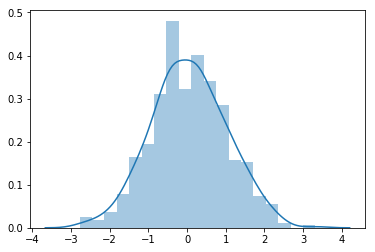

In [21]:
sns.distplot(x)

In [22]:
print(stats(x))

(tensor(0.0542), tensor(0.9763))


In [37]:
# let's now feed this through a 100 layer network
for i in range(100):
    x = a @ x
    
print(stats(x))

(tensor(nan), tensor(nan))


In [28]:
# init function
def get_data(n_in=512):
    return torch.randn(n_in), torch.randn(n_in,n_in)

In [67]:
# How many layers does it take to explode?
x, a = get_data()

for i in range(100):
    if not torch.isnan(x.mean()):
        x = a @ x
    else:
        break
print(i), print(stats(x))

28
(tensor(nan), tensor(1.0588e+38))


(None, None)

In [81]:
# let's create a testing function
def test_init(x, a, num_layers=100):
    """
    will test statistics of different inialization techniques for linear deep models.
    
    ARGS:
        x: input vector
        a: weight matrix
        num_layers: number of layers in the network
    """
    init_stats=stats(x)
    
    for i in range(num_layers):
        if not torch.isnan(x.mean()): x = a @ x
        else: break
    
    final_stats=stats(x)
    
    return i+1, init_stats, final_stats

In [82]:
# testing normally distributed weights
test_init(*get_data())

(29, (tensor(-0.0100), tensor(0.9700)), (tensor(nan), tensor(7.1718e+37)))

## A first intuitive solution
Intuitively, since the product of ```a``` and ```x``` is becoming large, we may start by reducing the magnitude of a matrix ```a```. The hope is that because of a smaller ```a```, the product ```a * x``` won't shoot up in magnitude. 

Thus, we divide our matrix by a ```scaling_factor``` of 100, and repeat the process

In [91]:
# grabbing our data with new weight initialization 
# and testing
x, a = get_data()
a = a/100

test_init(x, a)

(100, (tensor(0.0108), tensor(0.9961)), (tensor(0.), tensor(0.)))

So we have solved the problem of gradient explosion! But, now encounter a problem of vanishing gradients. 

## Xavier Initialization
We saw that using a ```scaling_factor``` of 100 didn't quite work. It reduced the product to 0. We had started with the problem of the magnitude exploding to infinity, and the scaling brought it down to 0. Surely, the right solution lies somewhere in the middle. 

That's exactly what the **Xavier Initialization** does: it helps us in finding a scaling factor that would get it right. 

The Xaviar initialization suggests using a scaling factor of $\sqrt{n_in}$ where ```n_in``` is the number of inputs to the matrix (or the dimensions that's common with the vector the matrix is being multiplied with).

In [96]:
import math

In [98]:
# let's create a xavier init function!
def xavier_init(x, a):
    """
    Will return a weight matrix initialized with xavier init
    """
    scaling_factor = math.sqrt(x.shape[0])
    a = a / scaling_factor
    
    return a

In [104]:
# let's now test with xavier init!
x, a = get_data()
a = xavier_init(x, a)

test_init(x, a)

(100, (tensor(0.0136), tensor(1.0437)), (tensor(0.0618), tensor(1.6694)))

In [106]:
# let's now test with xavier init! 10000 layers
x, a = get_data()
a = xavier_init(x, a)

test_init(x, a, 10000)

(2530, (tensor(-0.0506), tensor(1.0354)), (tensor(nan), tensor(4.2649e+37)))

The magnitude of the product hasn't exploded or vanished. In fact, the output has a nice mean close to 0 and std close to 1. 

This solution managed to retain the distribution of the inputs. 

Putting things in context, this translates to being allowed to train really deep neural networks. 

But as we see with much larger networks this is still a problem.

# Testing Optimized vs Normal for different layers

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [29]:
# our functions to init 
# optimized linear and non linear layer
class Relu_Opt():
    def __call__(self, x): return x.clamp_min(.0) - 0.5

class Linear():
    def __init__(self, w, b): self.w, self.b = w, b
    def __call__(self, x): return x@self.w + self.b

def get_data(num_in=512, method='kaiming'):
    """
    Returns x, w (kaiming init), b
    """
    x = torch.randn(num_in)
    
    if method=='kaiming':
        w = torch.randn(num_in, num_in) / math.sqrt(x.shape[0])
    elif method=='optimized':
        w = torch.randn(num_in, num_in) * math.sqrt(2/x.shape[0])
    else:
        print('randn initialization')
        w = torch.randn(num_in, num_in)
        
    b = torch.zeros(num_in)
    
    return x, w, b

In [3]:
class Model_Pytorch(nn.Module):
    def __init__(self, num_in):
        super().__init__()
        self.layer = [nn.Linear(num_in, num_in), nn.ReLU()]
        
    def __call__(self, x, num_layers, plot_stats=False):
        """
        Will return the stats of the activations initially and upon exploding or vanish. Will also (first) return when 
        """
        
        init_stats = stats(x)
        in_x = x
        
        with torch.no_grad():
        
            # looping through num_layers
            for i in range(num_layers):
                if not torch.isnan(x.mean()):
                    # getting our activation from the layer
                    for l in self.layer: x = l(x)
        
        final_stats = stats(x)
        
        print(f'Iteration: {i+1}')
        print(f'Initial Activation Stats: {init_stats}')
        print(f'Final Activation Stats: {final_stats}')
        
        if plot_stats:
            f, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
            sns.distplot(in_x, ax=axes[0])
            sns.distplot(x, ax=axes[1])
        
        return i+1, init_stats, final_stats

In [4]:
class Model_Optimized():
    def __init__(self, data):
        """
        data = (x, w, b)
        """
        self.x = data[0]
        self.w = data[1]
        self.b = data[2]
        
        # initializing our layers
        self.linear = Linear(self.w, self.b)
        self.relu = Relu_Opt()
        
        self.layer = [self.linear, self.relu]
        
    def __call__(self, x, num_layers, plot_stats=False):
        """
        Will return the stats of the activations initially and upon exploding or vanish. Will also (first) return when 
        """
        
        init_stats = stats(x)
        in_x = x
        
        # looping through num_layers
        for i in range(num_layers):
            if not torch.isnan(x.mean()):
                # getting our activation from the layer
                for l in self.layer: x = l(x)
        
        final_stats = stats(x)
        
        print(f'Iteration: {i+1}')
        print(f'Initial Activation Stats: {init_stats}')
        print(f'Final Activation Stats: {final_stats}')
        
        if plot_stats:
            f, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
            sns.distplot(in_x, ax=axes[0])
            sns.distplot(x, ax=axes[1])
        
        return i+1, init_stats, final_stats

# 1 Layer - Test

Iteration: 1
Initial Activation Stats: (tensor(-0.0318), tensor(1.0115))
Final Activation Stats: (tensor(0.2157), tensor(0.3185))


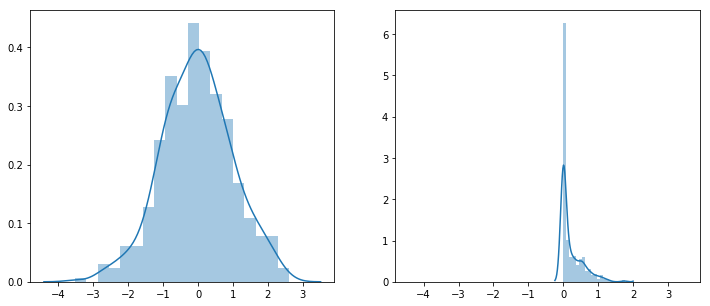

In [284]:
"""
TESTING: Pytorch Model
layers = 1
"""
num_layers = 1
num_in = 512

# grabbing data
x, _, _ = get_data()

# initializing our model
model = Model_Pytorch(num_in)

# simulating 100 layers
_= model(x, num_layers, plot_stats=True)

Iteration: 1
Initial Activation Stats: (tensor(0.0237), tensor(0.9928))
Final Activation Stats: (tensor(0.0056), tensor(0.7354))


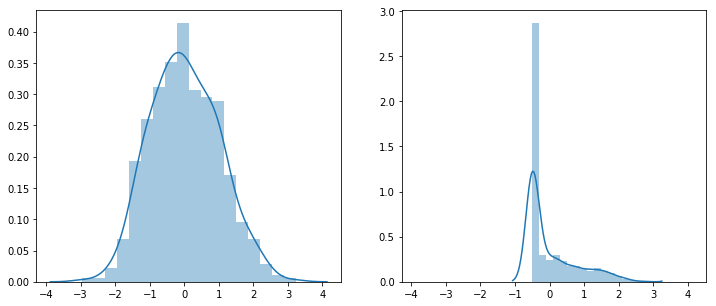

In [287]:
"""
TESTING: Optimized Model
layers = 1
"""
num_layers = 1
num_in = 512

# grabbing data
data = get_data(method='optimized')
x = data[0]

# initializing our model
model = Model_Optimized(data)

# simulating 100 layers
_= model(x, num_layers, plot_stats=True)

# 10 layer test

Iteration: 10
Initial Activation Stats: (tensor(0.0390), tensor(0.9910))
Final Activation Stats: (tensor(0.0115), tensor(0.0157))


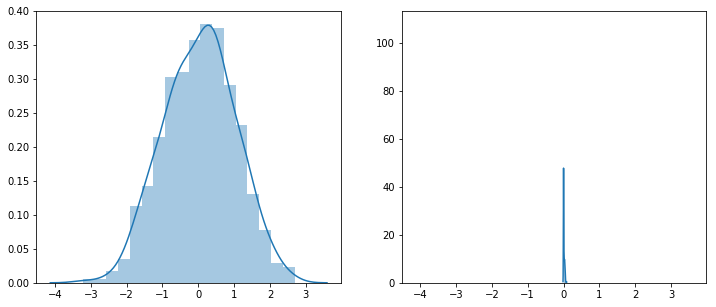

In [288]:
"""
TESTING: Pytorch Model
layers = 10
"""
num_layers = 10
num_in = 512

# grabbing data
x, _, _ = get_data()

# initializing our model
model = Model_Pytorch(num_in)

# simulating 100 layers
_= model(x, num_layers, plot_stats=True)

Iteration: 10
Initial Activation Stats: (tensor(-0.0097), tensor(1.0140))
Final Activation Stats: (tensor(-0.2329), tensor(0.3676))


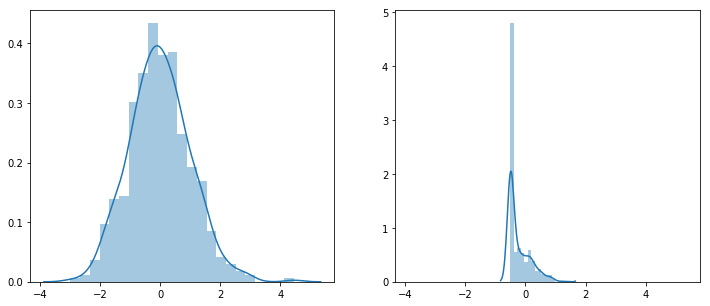

In [289]:
"""
TESTING: Optimized Model
layers = 10
"""
num_layers = 10
num_in = 512

# grabbing data
data = get_data(method='optimized')
x = data[0]

# initializing our model
model = Model_Optimized(data)

# simulating 100 layers
_= model(x, num_layers, plot_stats=True)

# 100 Layer Test

Iteration: 10
Initial Activation Stats: (tensor(-0.0486), tensor(0.9925))
Final Activation Stats: (tensor(0.0114), tensor(0.0154))


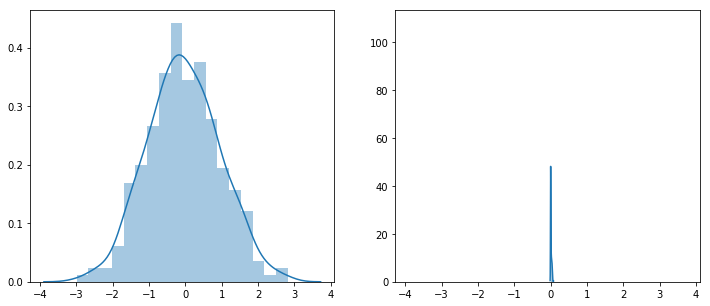

In [290]:
"""
TESTING: Pytorch Model
layers = 10
"""
num_layers = 10
num_in = 512

# grabbing data
x, _, _ = get_data()

# initializing our model
model = Model_Pytorch(num_in)

# simulating 10 layers
_= model(x, num_layers, plot_stats=True)

Iteration: 100
Initial Activation Stats: (tensor(0.0484), tensor(1.0059))
Final Activation Stats: (tensor(-0.2854), tensor(0.3215))


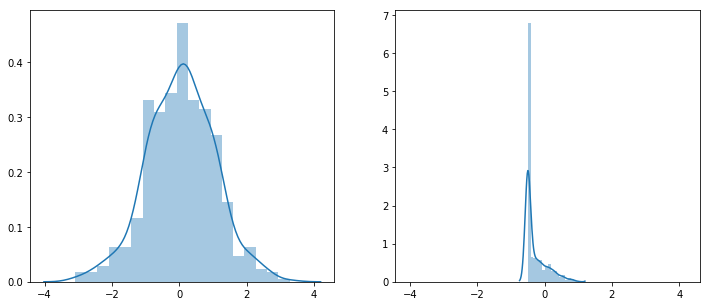

In [291]:
"""
TESTING: Optimized Model
layers = 100
"""
num_layers = 100
num_in = 512

# grabbing data
data = get_data(method='optimized')
x = data[0]

# initializing our model
model = Model_Optimized(data)

# simulating 100 layers
_= model(x, num_layers, plot_stats=True)

Iteration: 1000
Initial Activation Stats: (tensor(-0.0798), tensor(0.9357))
Final Activation Stats: (tensor(-0.2415), tensor(0.3728))


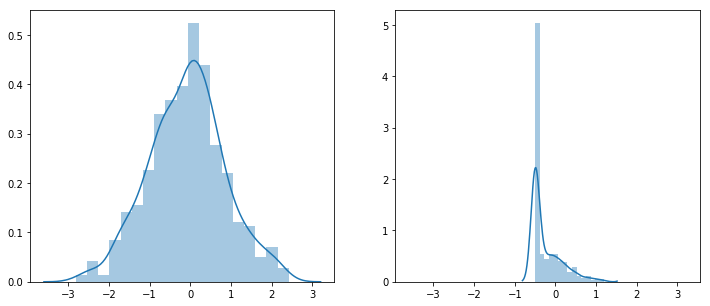

In [292]:
"""
TESTING: Optimized Model
layers = 1000
"""
num_layers = 1000
num_in = 512

# grabbing data
data = get_data(method='optimized')
x = data[0]

# initializing our model
model = Model_Optimized(data)

# simulating 100 layers
_= model(x, num_layers, plot_stats=True)

Iteration: 10000
Initial Activation Stats: (tensor(-0.0617), tensor(1.0033))
Final Activation Stats: (tensor(-0.2557), tensor(0.3566))


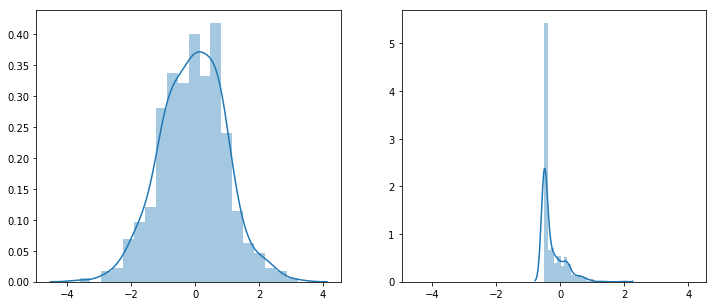

In [293]:
"""
TESTING: Optimized Model
layers = 10000
"""
num_layers = 10000
num_in = 512

# grabbing data
data = get_data(method='optimized')
x = data[0]

# initializing our model
model = Model_Optimized(data)

# simulating 100 layers
_= model(x, num_layers, plot_stats=True)

## Non-Zero Mean 
From looking at our experiments we can conclude that both ```pytorch``` and ```optimized``` models will suffer in learning when introducing very deep networks. 

In the case of our ```pytorch``` model, the problem is more of a dead neuron problem in which the activations of latent layers are too small and very close to zero. The reason this causes **Dead Neurons** has to do with the geometry of the ReLU. Anything below zero will simply have a a gradient of zero and therefor will be totally inactive and unreponsive towards any input.

In the case of oru ```optimzied``` model we are faced with a **non-zero mean** which can become a massive problem with delta-learning (back propogation) as it will simply slow down learning (making it computationally inneficient). 

The reason being, the gradients will either be largely positive or largely negative causing convergence to swing a lot when reaching the desired global minimum of the function. 

### What we want
Ideally, we are aiming for:
* Normalized output: mean = 0, std = 1 | Zero-centered function

In [38]:
x = torch.tensor(-12.)
m = nn.LeakyReLU()
m2 = nn.ReLU()

m(x), m2(x)

(tensor(-0.1200), tensor(0.))

Let's test a leaky relu and optimized leaky relu

In [62]:
class Leaky_Model(Model_Pytorch):
    def __init__(self, num_in):
        super().__init__(num_in)
        self.layer = [nn.Linear(num_in, num_in), nn.LeakyReLU()]

Iteration: 1
Initial Activation Stats: (tensor(-0.0304), tensor(0.9965))
Final Activation Stats: (tensor(0.2213), tensor(0.3419))


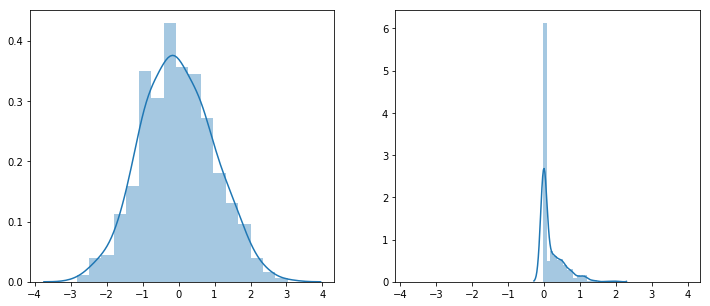

In [63]:
"""
TESTING: Leaky Model
layers = 1
"""
num_layers = 1
num_in = 512

# grabbing data
x, _, _ = get_data()

# initializing our model
model = Leaky_Model(num_in)

# simulating 100 layers
_= model(x, num_layers, plot_stats=True)

Iteration: 10
Initial Activation Stats: (tensor(-0.0115), tensor(1.0774))
Final Activation Stats: (tensor(0.0115), tensor(0.0158))


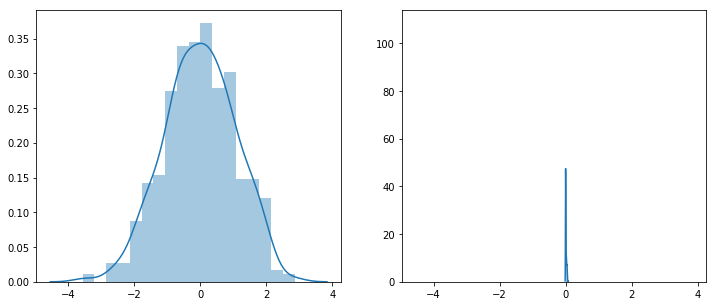

In [64]:
"""
TESTING: Leaky Model
layers = 10
"""
num_layers = 10
num_in = 512

# grabbing data
x, _, _ = get_data()

# initializing our model
model = Leaky_Model(num_in)

# simulating 100 layers
_= model(x, num_layers, plot_stats=True)

# Smooth Relu - ```nn.ELU```
Let's now test with a smooth relu

In [75]:
class Model_ELU(Model_Pytorch):
    def __init__(self, num_in):
        super().__init__(num_in)
        self.layer = [nn.Linear(num_in, num_in), nn.ELU()]

Iteration: 1
Initial Activation Stats: (tensor(-0.1102), tensor(1.0162))
Final Activation Stats: (tensor(0.0634), tensor(0.4886))


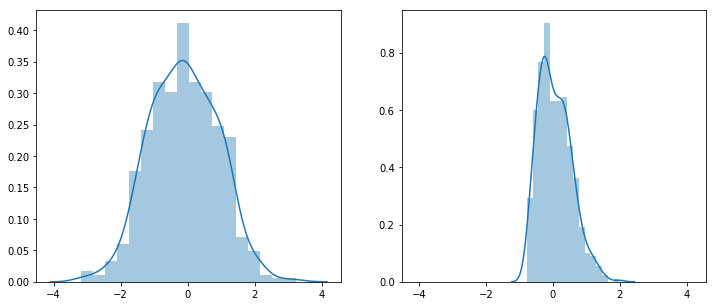

In [76]:
"""
TESTING: Sooth RELU: ELU
layers = 1
"""
num_layers = 1
num_in = 512

# grabbing data
x, _, _ = get_data()

# initializing our model
model = Model_ELU(num_in)

# simulating layers
_= model(x, num_layers, plot_stats=True)

Iteration: 10
Initial Activation Stats: (tensor(0.0470), tensor(0.9721))
Final Activation Stats: (tensor(-0.0001), tensor(0.0311))


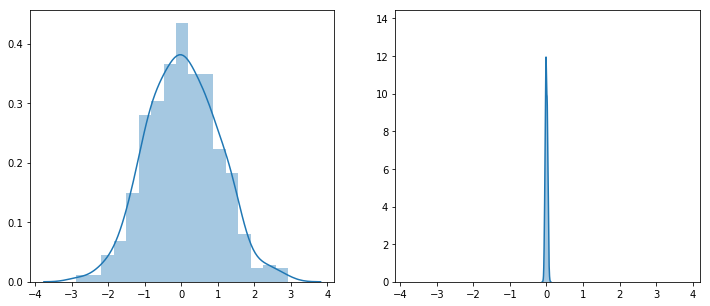

In [77]:
"""
TESTING: Sooth RELU: ELU
layers = 1
"""
num_layers = 10
num_in = 512

# grabbing data
x, _, _ = get_data()

# initializing our model
model = Model_ELU(num_in)

# simulating layers
_= model(x, num_layers, plot_stats=True)

Iteration: 100
Initial Activation Stats: (tensor(-0.0119), tensor(1.0061))
Final Activation Stats: (tensor(0.0012), tensor(0.0319))


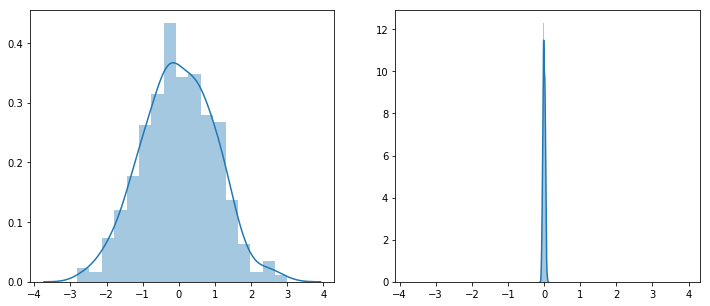

In [78]:
"""
TESTING: Sooth RELU: ELU
layers = 1
"""
num_layers = 100
num_in = 512

# grabbing data
x, _, _ = get_data()

# initializing our model
model = Model_ELU(num_in)

# simulating layers
_= model(x, num_layers, plot_stats=True)

Iteration: 1000
Initial Activation Stats: (tensor(-0.0623), tensor(0.9637))
Final Activation Stats: (tensor(-0.0001), tensor(0.0288))


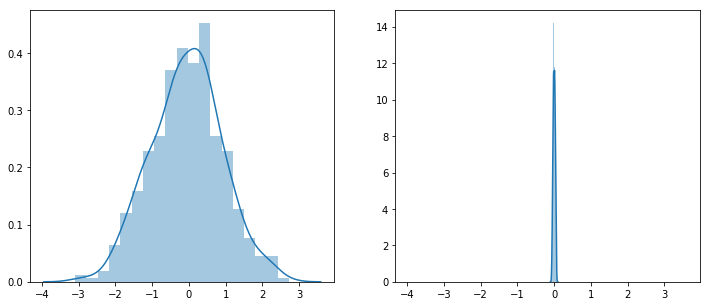

In [79]:
"""
TESTING: Sooth RELU: ELU
layers = 1
"""
num_layers = 1000
num_in = 512

# grabbing data
x, _, _ = get_data()

# initializing our model
model = Model_ELU(num_in)

# simulating layers
_= model(x, num_layers, plot_stats=True)

# Mish: A Self Regularized Non-Monotonic Neural Activation Function
https://arxiv.org/vc/arxiv/papers/1908/1908.08681v1.pdf

The concept of non-linearity in a Neural Network is introduced by an activation function which serves an integral role in the training and performance evaluation of the network. Over the years of theoritical research, many activation functions have been proposed, however, only a few are widely used in mostly all applications which include: ```ReLU, TanH, Sigmoid, LeakyReLU, Swish```. 

**Mish** can be defined as: 
```python
def mish(x):
    return x * torch.tanh(F.softplus(x))
```

Although it's difficult to explain the reason why one activation function peforms better than another due to many other training factors, the properties of Mish like being unbounded above, bounded below, smooth and non-monotonic, all play a significant role in the improvement results. 

Being unbounded above is a desirable property for any activation function since it avoids saturation which generally causes training to drastically slow down due to near-zero gradients. Being bounded below is also advantageous since it results in strong regularization effects. 

The non-monotonic property of Mish causes small negative inputs to be preserved as negerative outputs, which improves expressivity and gradient flow. 

The other of continuity being infinite for Mish is also a benefit over ReLU sinze ReLU has an order of continuity as 0 which means it's not continuously differentiable causing some undesired problems in gradient-based optimization. 

### Mish Testing
We will now test our ```Mish``` Activation with ```PyTorch``` methods and other weight initialization methods

In [86]:
class mish():
    def __call__(self, x): return x * torch.tanh(F.softplus(x))

In [128]:
# Let's now experiment and test a mish activation
class Model_Mish_Pytorch(Model_Pytorch):
    def __init__(self, num_in):
        super().__init__(num_in)
        self.mish = mish()
        self.layers = [nn.Linear(num_in, num_in), self.mish]

In [129]:
class Model_Mish_Optimized(Model_Optimized):
    def __init__(self, data):
        super().__init__(data)
        self.mish = mish()
        self.layer = [self.linear, self.mish]

Iteration: 1
Initial Activation Stats: (tensor(0.0296), tensor(0.9671))
Final Activation Stats: (tensor(0.2186), tensor(0.3333))


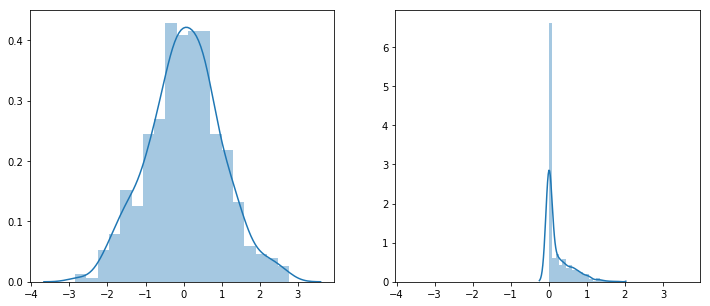

In [130]:
"""
TESTING: Mish Model
layers = 1
"""
num_layers = 1
num_in = 512

# grabbing data
x, _, _ = get_data()

# initializing our model
model = Model_Mish_Pytorch(num_in)

# simulating layers
_= model(x, num_layers, plot_stats=True)

Iteration: 10
Initial Activation Stats: (tensor(-0.0154), tensor(1.0011))
Final Activation Stats: (tensor(0.0115), tensor(0.0159))


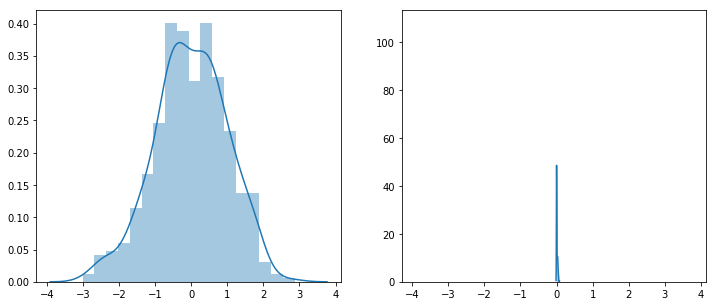

In [132]:
"""
TESTING: Mish Model
layers = 10
"""
num_layers = 10
num_in = 512

# grabbing data
x, _, _ = get_data()

# initializing our model
model = Model_Mish_Pytorch(num_in)

# simulating layers
_= model(x, num_layers, plot_stats=True)

Iteration: 1
Initial Activation Stats: (tensor(0.0459), tensor(0.9804))
Final Activation Stats: (tensor(0.3707), tensor(0.8185))


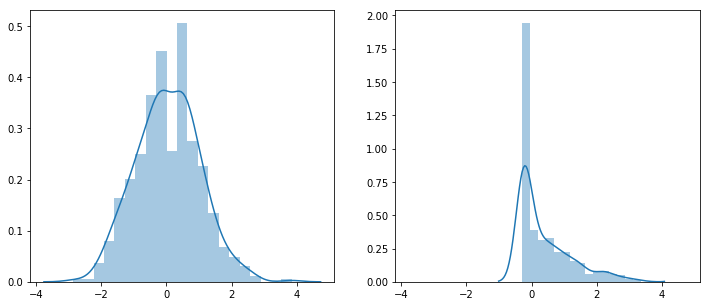

In [131]:
"""
TESTING: Optimized Model
layers = 1
"""
num_layers = 1
num_in = 512

# grabbing data
data = get_data(method='optimized')
x = data[0]

# initializing our model
model = Model_Mish_Optimized(data)

# simulating 100 layers
_= model(x, num_layers, plot_stats=True)

Iteration: 10
Initial Activation Stats: (tensor(-0.0076), tensor(1.0261))
Final Activation Stats: (tensor(0.2432), tensor(0.6387))


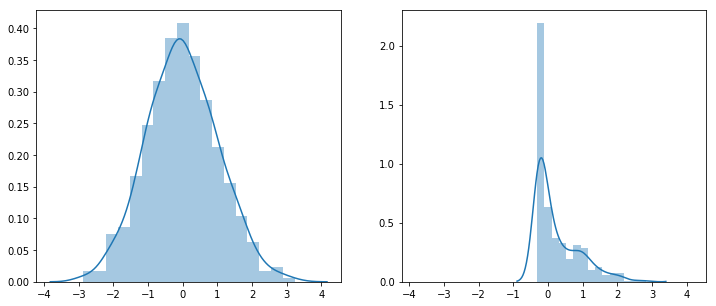

In [133]:
"""
TESTING: Optimized Model
layers = 1
"""
num_layers = 10
num_in = 512

# grabbing data
data = get_data(method='optimized')
x = data[0]

# initializing our model
model = Model_Mish_Optimized(data)

# simulating 100 layers
_= model(x, num_layers, plot_stats=True)